# Сборный проект 2.
# Прогноз эффективности обогащения рудного концентрата.

## Постановка задачи
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
Вам нужно:
- Подготовить данные;
- Провести исследовательский анализ данных;
- Построить и обучить модель.

## Описание данных
### Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

### Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

### Наименование признаков
Наименование признаков должно быть такое: `[этап].[тип_параметра].[название_параметра]`
Пример: `rougher.input.feed_ag`
Возможные значения для блока `[этап]`:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
Возможные значения для блока `[тип_параметра]`:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

Метрика качества
Для решения задачи введём новую метрику качества — **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

## Шаг 1. Подготовьте данные.
### 1.1. Откройте файлы и изучите их.

In [1]:
# Импорт нужных библиотек и классов

# Общие библиотеки
import pandas as pd
import numpy as np
# Графики
import matplotlib.pyplot as plt
import seaborn as sns
# MAE
from sklearn.metrics import mean_absolute_error
# Масштабирование
from sklearn.preprocessing import StandardScaler
import joblib
# Алгоритм классификации - решающее дерево
from sklearn.tree import DecisionTreeRegressor
# Алгоритм классификации - случайный лес
from sklearn.ensemble import RandomForestRegressor
# Алгоритм классификации - логистическая регрессия
from sklearn.linear_model import LinearRegression
# Механизм GridSearchCV
from sklearn.model_selection import GridSearchCV
# Механизм StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# Механизм make_scorer
from sklearn.metrics import make_scorer

In [2]:
train_df = pd.read_csv('gold_recovery_train.csv')
test_df = pd.read_csv('gold_recovery_test.csv')
full_df = pd.read_csv('gold_recovery_full.csv')

In [3]:
print('test_df : ')
test_df.info()
print('\ntrain_df : ')
train_df.info()
print('\nfull_df : ')
full_df.info()

test_df : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64

Видим, что в тестовой выборке присутствуют не все столбцы. Также имеются пропуски в данных во всех трёх наборах данных.

### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака `rougher.output.recovery`. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [4]:
# Функция для расчёта эффективности обогащения
def recovery_calc(df, c, f, t, new_column):
    df[new_column] = (df[c]*(df[f] - df[t]))/(df[f]*(df[c]-df[t]))*100

temp_train_df = train_df[train_df['rougher.output.recovery'].isna()==False]

# Непосредственно расчёт эффективности обогащения после флотации
recovery_calc(
    temp_train_df,
    'rougher.output.concentrate_au',
    'rougher.input.feed_au',
    'rougher.output.tail_au',
    'rougher.output.recovery_calculated'
)

# Расчёт MAE для столбцов rougher.output.recovery и rougher.output.recovery_calculated
recovery_mae = mean_absolute_error(temp_train_df['rougher.output.recovery_calculated'], temp_train_df['rougher.output.recovery'])
print('MAE =', recovery_mae)

MAE = 9.444891926100695e-15


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Видим, что среднее абсолютное отклонение получилось очень маленьким. Может быть эта ошибка обусловлена точностью вычислений при работе с плавающей точкой.

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [5]:
# Столбцы, которых нет в тестовой выборке
columns_not_exist_in_test = set(train_df.columns).difference(set(test_df.columns))
for col in sorted(columns_not_exist_in_test):
    print(col)

final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_au
secondary_cleaner.

В тестовой выборке отсутствуют столбцы с выходными параметрами на всех этапах + столбцы с расчётными характеристиками на этапе флотационной обработки.
В условии задачи было сказано, что в тестовой выборке некоторых параметров нет, т.к. они определяются позднее.

### 1.4. Проведите предобработку данных.

In [6]:
# Поиск полных строк дубликатов
duplicated_train = train_df[train_df.duplicated()]
print(duplicated_train)

duplicated_test = test_df[test_df.duplicated()]
print(duplicated_test)

duplicated_full = full_df[full_df.duplicated()]
print(duplicated_full)

Empty DataFrame
Columns: [date, final.output.concentrate_ag, final.output.concentrate_pb, final.output.concentrate_sol, final.output.concentrate_au, final.output.recovery, final.output.tail_ag, final.output.tail_pb, final.output.tail_sol, final.output.tail_au, primary_cleaner.input.sulfate, primary_cleaner.input.depressant, primary_cleaner.input.feed_size, primary_cleaner.input.xanthate, primary_cleaner.output.concentrate_ag, primary_cleaner.output.concentrate_pb, primary_cleaner.output.concentrate_sol, primary_cleaner.output.concentrate_au, primary_cleaner.output.tail_ag, primary_cleaner.output.tail_pb, primary_cleaner.output.tail_sol, primary_cleaner.output.tail_au, primary_cleaner.state.floatbank8_a_air, primary_cleaner.state.floatbank8_a_level, primary_cleaner.state.floatbank8_b_air, primary_cleaner.state.floatbank8_b_level, primary_cleaner.state.floatbank8_c_air, primary_cleaner.state.floatbank8_c_level, primary_cleaner.state.floatbank8_d_air, primary_cleaner.state.floatbank8_d_le

In [7]:
# Метод преобразования типа object в дату
def convert_to_date(df, column_name):
    df[column_name] =  pd.to_datetime(df[column_name], format='%Y-%m-%d %H:%M:%S')

# Преобразуем столбец 'date' во всех датасетах в тип datetime
convert_to_date(train_df, 'date')
convert_to_date(test_df, 'date')
convert_to_date(full_df, 'date')

In [8]:
# Заполним целевые признаки в тестовом датасете из полного датасета
test_df['rougher.output.recovery'] = test_df.merge(full_df, on='date', how='inner')['rougher.output.recovery']
test_df['final.output.recovery'] = test_df.merge(full_df, on='date', how='inner')['final.output.recovery']

In [9]:
# Заполним целевой признак rougher.output.recovery там где он пропущен и там где не будет деления на ноль при вычислении в обучающем датасете с помощью формулы для Recovery
def recovery_calc_row(row, c, f, t):
    if not pd.isna(row['rougher.output.recovery']):
        return row['rougher.output.recovery']
    else:
        try:
            return (row[c]*(row[f] - row[t]))\
                   /(row[f]*(row[c]-row[t]))*100
        except ZeroDivisionError:
            return row['rougher.output.recovery']

train_df['rougher.output.recovery'] = train_df.apply(recovery_calc_row, c='rougher.output.concentrate_au', f='rougher.input.feed_au', t='rougher.output.tail_au', axis=1)

In [10]:
# Избавляемся от строк с пустыми целевыми признаками к обучающем и тестовом датасетах
train_df.dropna(subset=['rougher.output.recovery'], inplace=True)
train_df.dropna(subset=['final.output.recovery'], inplace=True)

test_df.dropna(subset=['rougher.output.recovery'], inplace=True)
test_df.dropna(subset=['final.output.recovery'], inplace=True)

In [11]:
# Заполняем отсутствующие значения предудыщими присутствующими
train_df.fillna(method='ffill', inplace=True)
test_df.fillna(method='ffill', inplace=True)
full_df.fillna(method='ffill', inplace=True)

Шаги предобработки:
- полных дубликатов в строках не оказалось
- столбцу **date** во всех датасетах задали тип datetime. Остальные типы столбцов соответствуют своему предназначению.
- заполнили целевые признаки **rougher.output.recovery** и **final.output.recovery** в тестовом датасете из полного датасета
- заполнили отсутствующий целевой признак **rougher.output.recovery** в обучающем датасете по формуле Recovery где это возможно
- убрали строки в тестовом и обучающем датасетах с отсутствующими целевыми признаками recovery
- заполнили отсутствующие значения с помощью метода ffill.

## Шаг 2. Проанализируйте данные.
### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

              name         au         ag        pb
0          rougher  17.831509  10.845609  6.886869
1  primary_cleaner  29.119967   7.666972  8.809217
2            final  39.891718   4.768013  9.071366


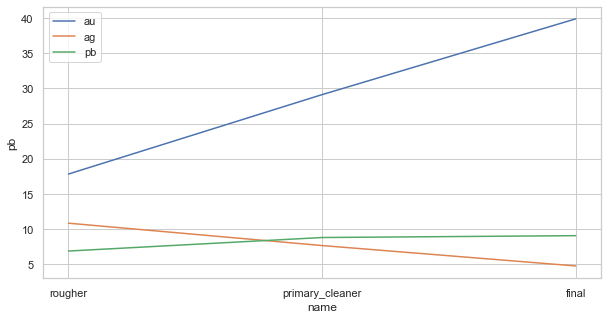

In [12]:
# Найдем средние значения концентрации металлов
rougher_au = full_df['rougher.output.concentrate_au'].mean()
primary_cleaner_au = full_df['primary_cleaner.output.concentrate_au'].mean()
final_au = full_df['final.output.concentrate_au'].mean()

rougher_ag = full_df['rougher.output.concentrate_ag'].mean()
primary_cleaner_ag = full_df['primary_cleaner.output.concentrate_ag'].mean()
final_ag = full_df['final.output.concentrate_ag'].mean()

rougher_pb = full_df['rougher.output.concentrate_pb'].mean()
primary_cleaner_pb = full_df['primary_cleaner.output.concentrate_pb'].mean()
final_pb = full_df['final.output.concentrate_pb'].mean()

d = {'name': ['rougher', 'primary_cleaner', 'final'],
     'au': [rougher_au, primary_cleaner_au, final_au],
     'ag': [rougher_ag, primary_cleaner_ag, final_ag],
     'pb': [rougher_pb, primary_cleaner_pb, final_pb]}
concentrate_df = pd.DataFrame(data=d)

print(concentrate_df.head())

sns.set(style='whitegrid')
plt.figure(figsize=(10,5))
sns.lineplot(y='au', x = 'name', data=concentrate_df, legend='brief', label='au', sort=False)
sns.lineplot(y='ag', x = 'name', data=concentrate_df, legend='brief', label='ag', sort=False)
sns.lineplot(y='pb', x = 'name', data=concentrate_df, legend='brief', label='pb', sort=False)
plt.show()

Видим, что среднее значение концентрации золота и свинца растёт от этапа к этапу, а серебра падает. Это можно объяснить тем, что золото и свинец имеют примерно одинаковую атомную массу и расположены относительно близко в таблице Менделеева.

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

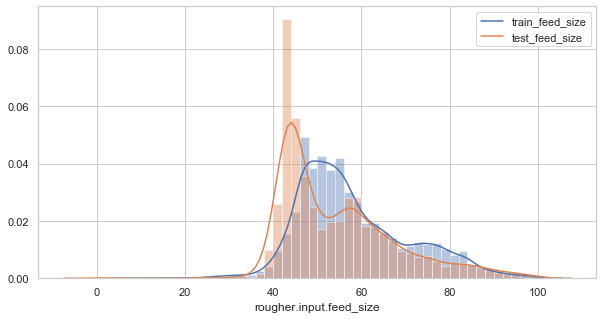

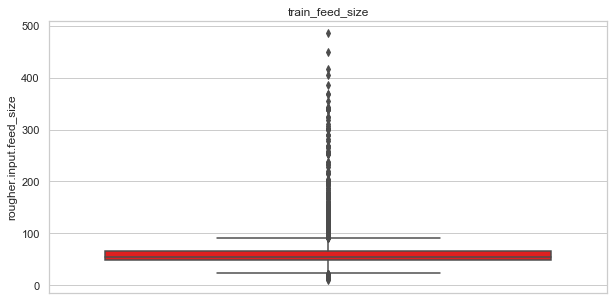

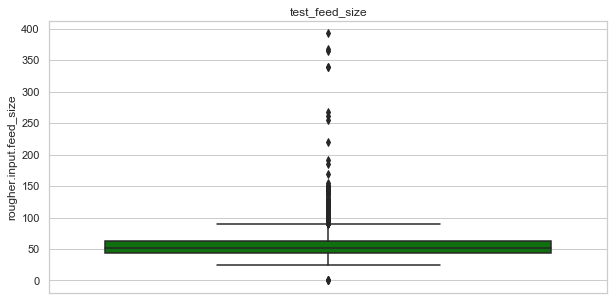

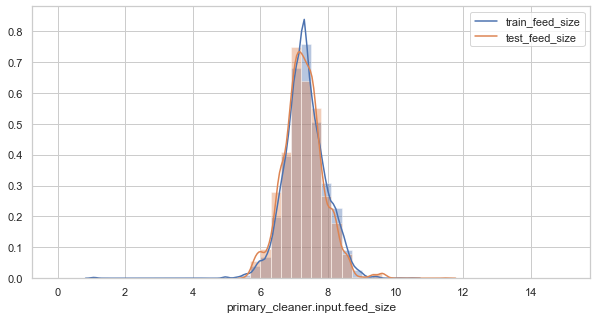

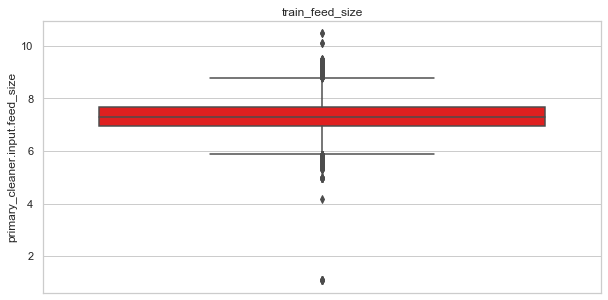

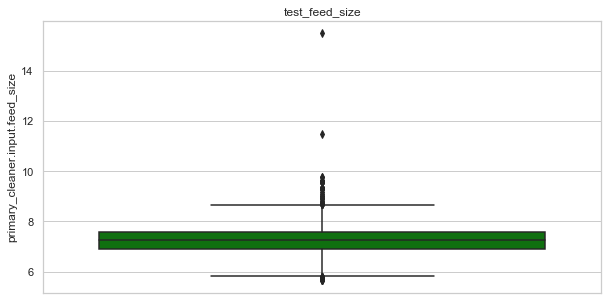

In [13]:
# Распределение размеров гранул сырья на входе во флотационную очистку
plt.figure(figsize=(10,5))
sns.distplot(train_df['rougher.input.feed_size'], kde_kws={"clip":(0,100), 'label':'train_feed_size'}, hist_kws={"range":(0,100)})
sns.distplot(test_df['rougher.input.feed_size'], kde_kws={"clip":(0,100), 'label':'test_feed_size'}, hist_kws={"range":(0,100)})
plt.show()

# Ящик с усами для размеров гранул сырья на входе во флотационную очистку
plt.figure(figsize=(10,5))
sns.boxplot(data=train_df, y='rougher.input.feed_size', color='red').set_title('train_feed_size')
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(data=test_df, y='rougher.input.feed_size', color='green').set_title('test_feed_size')
plt.show()

# Распределение размеров гранул сырья на входе в первичную очистку
plt.figure(figsize=(10,5))
sns.distplot(train_df['primary_cleaner.input.feed_size'], kde_kws={"clip":(0,15), 'label':'train_feed_size'}, hist_kws={"range":(0,15)})
sns.distplot(test_df['primary_cleaner.input.feed_size'], kde_kws={"clip":(0,15), 'label':'test_feed_size'}, hist_kws={"range":(0,15)})
plt.show()

# Ящик с усами для размеров гранул сырья на входе в первичную очистку
plt.figure(figsize=(10,5))
sns.boxplot(data=train_df, y='primary_cleaner.input.feed_size', color='red').set_title('train_feed_size')
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(data=test_df, y='primary_cleaner.input.feed_size', color='green').set_title('test_feed_size')
plt.show()

Видим, что распределение гранул сырья на этапах rougher и primary_cleaner примерно одни и те же для тестовой и обучающей выборок.
Для primary_cleaner распределение близко к нормальному, а для rougher похоже на распределение Пуассона.

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

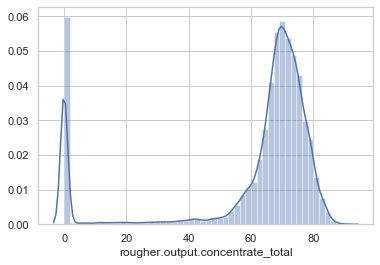

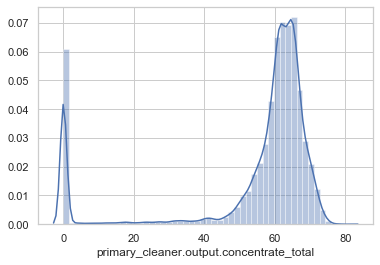

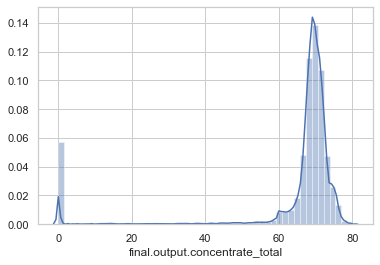

In [14]:
# Найдем суммарную концентрацию веществ на разных этапах
full_df['rougher.output.concentrate_total'] = full_df[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']].T.sum()
full_df['primary_cleaner.output.concentrate_total'] = full_df[['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au']].T.sum()
full_df['final.output.concentrate_total'] = full_df[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].T.sum()

# Построим графики распределения суммарных концентраций на разных этапах
sns.distplot(full_df['rougher.output.concentrate_total'])
plt.show()
sns.distplot(full_df['primary_cleaner.output.concentrate_total'])
plt.show()
sns.distplot(full_df['final.output.concentrate_total'])
plt.show()

Видим, что имеются аномалии для всех трех этапов на полном датасете - это суммарные концентрации равные нулю и значения около него. Возьмем за границу отсеивания концентрацию 20. Нужно избавиться от строк в датасетах, имеющих значения ниже порога.

In [15]:
# Избавляемся от аномальных по концентрациям строк во всех датасетах
full_df = full_df[full_df['rougher.output.concentrate_total'] > 20]
full_df = full_df[full_df['primary_cleaner.output.concentrate_total'] > 20]
full_df = full_df[full_df['final.output.concentrate_total'] > 20]

test_df = test_df[test_df['date'].isin(full_df['date'])]
train_df = train_df[train_df['date'].isin(full_df['date'])]

## 3. Постройте модель
### 3.1. Напишите функцию для вычисления итоговой sMAPE.

In [16]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def smape_total(smape_rougher, smape_final):
    return 0.25*smape_rougher + 0.75*smape_final

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

В данном пункте я попробую обучить 2 модели: первая - для предсказания целевого признака **rougher.output.recovery** и вторая для **final.output.recovery**.
Целью каждой модели будет минимизация smape для своего целевого признака, в итоге получим минимальное значение и для итоговой smape.
Так как в тестовом датасете отсутствуют целевые признаки, то сформируем отдельно 2 серии для них из полного датасета.

In [17]:
target_rougher_test = test_df['rougher.output.recovery']
target_final_test = test_df['final.output.recovery']

# Убираем из тестовой выборки целевые признаки
test_df = test_df.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = test_df.drop(['date'], axis=1)

Выделим признаки и целевые признаки для обучающей выборки. Для features_train нас будут интересовать только столбцы, которые уже есть в тестовой выборке.

In [18]:
features_train = train_df[features_test.columns]
target_rougher_train = train_df['rougher.output.recovery']
target_final_train = train_df['final.output.recovery']

Проведём масштабирование признаков

In [19]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Подбор гиперпараметров моделей
Попробуем подобрать оптимальные настройки моделей с помощью механизма GridSearchCV.

In [20]:
# Подбор параметра max_depth для модели решающего дерева
dtr = DecisionTreeRegressor(random_state=12345)
scorer = make_scorer(smape, greater_is_better=False)
param_grid = {
    'max_depth' : list(range(2, 6)),
}

CV_dtr = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5, scoring=scorer)
CV_dtr.fit(features_train, target_rougher_train)
print('Параметры модели решающего дерева для цел. признака rougher.output.recovery: ')
print(CV_dtr.best_params_)
print(CV_dtr.best_score_)
print(CV_dtr.best_estimator_)

CV_dtr = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5, scoring=scorer)
CV_dtr.fit(features_train, target_final_train)
print('Параметры модели решающего дерева для цел. признака final.output.recovery: ')
print(CV_dtr.best_params_)
print(CV_dtr.best_score_)
print(CV_dtr.best_estimator_)

Параметры модели решающего дерева для цел. признака rougher.output.recovery: 
{'max_depth': 5}
-7.182198119991714
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')
Параметры модели решающего дерева для цел. признака final.output.recovery: 
{'max_depth': 3}
-9.175131403833754
DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')


Лучшая глубина дерева для rougher.output.recovery равна 5 со значением smape=7.18, а для final.output.recovery max_depth=3 со значением smape=9.17 на обучающей выборке.

In [21]:
# Подбор параметра max_depth для модели слуйчаного леса
rfr = RandomForestRegressor(n_jobs=3, random_state=12345)
scorer = make_scorer(smape, greater_is_better=False)
param_grid = {
    'max_depth' : list(range(1, 10)),
    'n_estimators': list(range(1, 10)),
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring=scorer, verbose=10)
# Лучшие найденные параметры: max_depth=5, n_estimators=2, smape=9.5
# CV_rfr.fit(features_train, target_rougher_train)
# print('Параметры модели cлучайного леса для цел. признака rougher.output.recovery: ')
# print(CV_rfr.best_params_)
# print(CV_rfr.best_score_)
# print(CV_rfr.best_estimator_)

In [22]:
# Подбор параметра max_depth для модели слуйчаного леса
rfr = RandomForestRegressor(n_jobs=3, random_state=12345)
scorer = make_scorer(smape, greater_is_better=False)
param_grid = {
    'max_depth' : list(range(1, 5)),
    'n_estimators': list(range(40, 60)),
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring=scorer, verbose=10)
# Лучшие найденные параметры: max_depth=4, n_estimators=46, smape=8.84
# CV_rfr.fit(features_train, target_final_train)
# print('Параметры модели cлучайного леса для цел. признака final.output.recovery: ')
# print(CV_rfr.best_params_)
# print(CV_rfr.best_score_)
# print(CV_rfr.best_estimator_)

Лучшие параметры моделей случайного леса для rougher.output.recovery max_depth=5, n_estimators=2, со значением smape=9.5, а для final.output.recovery max_depth=4, n_estimators=46, со значением smape=8.84 на обучающей выборке.

Таким образом получаем, что лучший вариант для признака rougher.output.recovery это модель решающего дерева с max_depth=5 (smape=7.18), а для признака final.output.recovery - модель случайного леса max_depth=4, n_estimators=46 (smape=8.84).
Посчитаем итоговое значение smape_total для обучающей выборки.

In [23]:
# Проверяем модель для предсказания rougher.output.recovery на обучающей выборке
ror_model = DecisionTreeRegressor(max_depth=5,random_state=12345)
ror_model.fit(features_train, target_rougher_train)
predict_rougher_train = ror_model.predict(features_train)
ror_smape = smape(target_rougher_train, predict_rougher_train)
print('ror_smape = ', ror_smape)

# Проверяем модель для предсказания final.output.recovery на обучающей выборке
for_model = RandomForestRegressor(max_depth=4, n_estimators=46, random_state=12345)
for_model.fit(features_train, target_final_train)
predict_final_train = for_model.predict(features_train)
for_smape = smape(target_final_train, predict_final_train)
print('for_smape = ', for_smape)

smape_total_train = smape_total(ror_smape, for_smape)
print('Итоговое sMape на обучающей выборке: ', smape_total_train)

ror_smape =  4.7748954925790965
for_smape =  7.59636643069243
Итоговое sMape на обучающей выборке:  6.890998696164097


### Проверка моделей на адекватность

Проверим наши полученные модели на адекватность. Для этого посчитаем итоговое значение smape для обучающей выборки в том случае, когда наша условная модель предсказывает всегда среднее значение по выборке.
А затем сравним его с полученным значением smape_total_train.

In [24]:
predict_mean_rougher_train = pd.Series(target_rougher_train.mean(), index=range(0, len(target_rougher_train)))
predict_mean_final_train = pd.Series(target_final_train.mean(), index=range(0, len(target_final_train)))
smape_total_train_by_mean = smape_total(smape(target_rougher_train, predict_mean_rougher_train), smape(target_final_train, predict_mean_final_train))
print('Итоговое sMape на обучающей выборке с предсказанием по среднему = ', smape_total_train_by_mean)

Итоговое sMape на обучающей выборке с предсказанием по среднему =  7.424775961680362


Итоговое sMape на обучающей выборке с предсказанием по среднему оказалось больше, чем итоговое sMape на обучающей выборке, полученное с помощью обученных моделей.
Таким образом, видим, что наши модели адекватны.

In [25]:
# Проверяем модель для предсказания rougher.output.recovery на тестовой выборке
predict_rougher_test = ror_model.predict(features_test)
ror_smape = smape(target_rougher_test, predict_rougher_test)
print('ror_smape = ', ror_smape)

# Проверяем модель для предсказания final.output.recovery на тестовой выборке
predict_final_test = for_model.predict(features_test)
for_smape = smape(target_final_test, predict_final_test)
print('for_smape = ', for_smape)

smape_total_test = smape_total(ror_smape, for_smape)
print('Итоговое sMape на тестовой выборке: ', smape_total_test)

ror_smape =  5.53102603854054
for_smape =  8.305173014360848
Итоговое sMape на тестовой выборке:  7.611636270405771


## Вывод

В итоге выполнения проекта были обучены 2 модели для предсказания 2 величин:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Для первого признака была обучена модель решающего дерева, для второго признака - модель случайного леса.
Модели были проверены на адекватность на обучающей выборке.
Итоговая метрика sMape на тестовой выборке оказалась равна 7.6.
